# Set up
Import libraries

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt
import joblib

# K-fold Cross Validation
from sklearn.model_selection import GridSearchCV, GroupKFold

# classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance, oas, graphical_lasso
from sklearn.utils import shuffle

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

##Mount google drive and GCS

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   3995      0 --:--:-- --:--:-- --:--:--  3992
OK
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unsele

In [4]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723219033,"nanos":230412701},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723219033,"nanos":231074119},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [5]:
input_path = os.path.join(local_path, 'feature_matrices')

#test mounting
os.listdir(input_path)

['pca_results.pkl',
 'test_features_matrix.pkl',
 'test_label.pkl',
 'train_features_matrix.pkl',
 'train_label.pkl',
 'val_features_matrix.pkl',
 'validation_label.pkl']

# Load Train and Validation Features

In [6]:
feature_to_process = 'canny'

In [7]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [8]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


## Load Train and Validation Features

In [9]:
def load_features(feature_path, feature):
    train_fm = pickle.load(open(feature_path + '/' +  'train_' + feature + '_pca_95'  + '.pkl', 'rb'))
    val_fm = pickle.load(open(feature_path + '/' +  'validation_' + feature + '_pca_95'  +'.pkl', 'rb'))
    test_fm = pickle.load(open(feature_path + '/' +  'test_' + feature + '_pca_95'  + '.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [10]:
feature_path = os.path.join(local_path, 'features')
os.listdir(f"{feature_path}/")

['kmeans_model.pkl',
 'sift_test_features_matrix_95.pkl',
 'sift_train_features_matrix_95.pkl',
 'sift_val_features_matrix_95.pkl',
 'test_canny.pkl',
 'test_canny_pca_95.pkl',
 'test_canny_std.pkl',
 'test_cnn.pkl',
 'test_cnn_pca_95.pkl',
 'test_cnn_std.pkl',
 'test_hog.pkl',
 'test_hog_pca_95.pkl',
 'test_hog_std.pkl',
 'test_sift.pkl',
 'test_sift_pca_95.pkl',
 'test_sift_std.pkl',
 'test_sobel.pkl',
 'test_sobel_pca_95.pkl',
 'test_sobel_std.pkl',
 'tfidf_transformer.pkl',
 'train_canny.pkl',
 'train_canny_pca_95.pkl',
 'train_canny_std.pkl',
 'train_cnn.pkl',
 'train_cnn_pca_95.pkl',
 'train_cnn_std.pkl',
 'train_hog.pkl',
 'train_hog_pca_95.pkl',
 'train_hog_std.pkl',
 'train_sift.pkl',
 'train_sift_pca_95.pkl',
 'train_sift_std.pkl',
 'train_sobel.pkl',
 'train_sobel_pca_95.pkl',
 'train_sobel_std.pkl',
 'validation_canny.pkl',
 'validation_canny_pca_95.pkl',
 'validation_canny_std.pkl',
 'validation_cnn.pkl',
 'validation_cnn_pca_95.pkl',
 'validation_cnn_std.pkl',
 'validatio

In [11]:
# loading feature vector for each set
x_train = load_features(feature_path,feature_to_process)[0]
x_val = load_features(feature_path,feature_to_process)[1]
x_test = load_features(feature_path,feature_to_process)[2]

In [ ]:
# # Convert to numpy arrays
# x_train = np.array(list(x_train.values()))
# x_val = np.array(list(x_val.values()))
# x_test = np.array(list(x_test.values()))

In [12]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sift_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sift_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sift_std' + '.pkl', 'rb'))

In [13]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({feature_to_process: [pca_vector for pca_vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({feature_to_process: [pca_vector for pca_vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({feature_to_process: [pca_vector for pca_vector in x_test]}, index = list(test_fm_ind.keys()))

In [14]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

# Combine train and validation feature dataframes

In [15]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)
df.head()


,label,group,canny
image,,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[32.45930203686977, -0.07080700346145857, -11...."
N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[34.11999163954386, -0.7945212056563972, -9.21..."
N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[32.0942719215761, -0.6100396700724054, -10.26..."
N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[34.32887939620074, -1.096339569920335, -9.792..."
N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[38.25199629200106, -3.3926007252707593, -8.08..."


# Grouped K-Fold Cross Validation

In [16]:
# X, y, and groups are your data and group labels
# specify feature columns
X = np.vstack(df[feature_to_process].to_numpy())
# label coluns
y = df['label']
# read group from labels
groups =  df['group']
# specify splits
splits = 5
# path storing outputs
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)


In [ ]:
# # Train model by solver to prevent colab from breaking
# # SVD solver

# model = LinearDiscriminantAnalysis()

# # parameter grid
# param_grid = [{
#     'solver': ['svd'],
#     'shrinkage': [None],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False, True],
#     'tol': [1e-4, 1e-5, 1e-6],
#     'covariance_estimator': [None]
#     }
#     #           {
#     # 'solver': ['lsqr'],
#     # 'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     # 'priors': [None],
#     # 'n_components': [None, 1, 2, 3, 4, 5],
#     # 'store_covariance': [False],
#     # 'covariance_estimator': [None]
#     # },
#     #           {
#     # 'solver': ['eigen'],
#     # 'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     # 'priors': [None],
#     # 'n_components': [None, 1, 2, 3, 4, 5],
#     # 'store_covariance': [False],
#     # 'covariance_estimator': [None]
#     # }
# ]

# #shuffle data, using random state = 281
# X, y, groups = shuffle(X, y, groups, random_state=281)

# # grouped k-fold
# gkf = GroupKFold(n_splits=splits)

# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=gkf,
#                            scoring='accuracy',
#                            verbose=2,
#                            n_jobs=1,
#                            return_train_score=True)



# # save intermediate steps in case colab gets disconnected
# intermediate_path = output_path + '/lda_grid_search_intermediate.pkl'

# # Check if intermediate results exist
# if os.path.exists(intermediate_path):
#     saved_state = joblib.load(intermediate_path)
#     grid_search = saved_state['grid_search']
#     last_iteration = saved_state['last_iteration']
#     print(f"Resuming grid search from iteration {last_iteration}.")
# else:
#     last_iteration = 0
#     print("Starting new grid search.")

# with tqdm(total=len([i['solver'] for i in param_grid]) * len([i['shrinkage'] for i in param_grid]) * len([i['n_components'] for i in param_grid]), desc="Grid Search") as pbar:
#     def callback(*args, **kwargs):
#         pbar.update(1)
#         # Save intermediate results every 5 updates
#         if pbar.n % 5 == 0:
#             joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

#     # Monkey patch the fit method to include the callback
#     original_fit = grid_search.fit
#     def fit_with_callback(*args, **kwargs):
#         original_fit(*args, **kwargs)
#         callback()

#     grid_search.fit = fit_with_callback

#     # Fit the model
#     grid_search.fit(X, y, groups=groups)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_score = grid_search.best_score_
# print("Best score found: ", best_score)

# train_score = grid_search.cv_results_
# print("train score: ", train_score.keys())

# # Save the final best model
# lda_best_model = grid_search.best_estimator_
# pickle.dump(lda_best_model, open(output_path + '/lda_hog_svd_best_model.pkl', 'wb'))

# # Save the final grid search results
# joblib.dump(grid_search, output_path + '/lda_hog_svd_grid_search_final.pkl')

# # Save the train scores
# # Save the train scores
# pickle.dump(train_score, open(output_path + '/lda_hog_svd_train_score.pkl', 'wb'))

In [ ]:
# Train model by solver to prevent colab from breaking
# lsqr solver

model = LinearDiscriminantAnalysis()

# parameter grid
param_grid = [
    # {
    # 'solver': ['svd'],
    # 'shrinkage': [None],
    # 'priors': [None],
    # 'n_components': [None, 1, 2, 3, 4, 5],
    # 'store_covariance': [False, True],
    # 'tol': [1e-4, 1e-5, 1e-6],
    # 'covariance_estimator': [None]
    # }
              {
    'solver': ['lsqr'],
    'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
    'priors': [None],
    'n_components': [None, 1, 2, 3, 4, 5],
    'store_covariance': [False],
    'covariance_estimator': [None]
    }
    #           {
    # 'solver': ['eigen'],
    # 'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
    # 'priors': [None],
    # 'n_components': [None, 1, 2, 3, 4, 5],
    # 'store_covariance': [False],
    # 'covariance_estimator': [None]
    # }
]

#shuffle data, using random state = 281
X, y, groups = shuffle(X, y, groups, random_state=281)

# grouped k-fold
gkf = GroupKFold(n_splits=splits)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=gkf,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1,
                           return_train_score=True)



# save intermediate steps in case colab gets disconnected
intermediate_path = output_path + '/lda_grid_search_'+feature_to_process+'_intermediate.pkl'

# Check if intermediate results exist
if os.path.exists(intermediate_path):
    saved_state = joblib.load(intermediate_path)
    grid_search = saved_state['grid_search']
    last_iteration = saved_state['last_iteration']
    print(f"Resuming grid search from iteration {last_iteration}.")
else:
    last_iteration = 0
    print("Starting new grid search.")

with tqdm(total=len([i['solver'] for i in param_grid]) * len([i['shrinkage'] for i in param_grid]) * len([i['n_components'] for i in param_grid]), desc="Grid Search") as pbar:
    def callback(*args, **kwargs):
        pbar.update(1)
        # Save intermediate results every 5 updates
        if pbar.n % 5 == 0:
            joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

    # Monkey patch the fit method to include the callback
    original_fit = grid_search.fit
    def fit_with_callback(*args, **kwargs):
        original_fit(*args, **kwargs)
        callback()

    grid_search.fit = fit_with_callback

    # Fit the model
    grid_search.fit(X, y, groups=groups)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_score = grid_search.best_score_
print("Best score found: ", best_score)

train_score = grid_search.cv_results_
print("train score: ", train_score.keys())

# Save the final best model
lda_best_model = grid_search.best_estimator_
pickle.dump(lda_best_model, open(output_path + '/lda_'+feature_to_process+'_lsqr_best_model.pkl', 'wb'))

# Save the final grid search results
joblib.dump(grid_search, output_path + '/lda_'+feature_to_process+'_lsqr_grid_search_final.pkl')

# Save the train scores
# Save the train scores
pickle.dump(train_score, open(output_path + '/lda_'+feature_to_process+'_lsqr_train_score.pkl', 'wb'))

Starting new grid search.


Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Grid Search: 100%|██████████| 1/1 [24:19<00:00, 1459.05s/it]


Best parameters found:  {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.6, 'solver': 'lsqr', 'store_covariance': False}
Best score found:  0.7265220433869839
train score:  dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_covariance_estimator', 'param_n_components', 'param_priors', 'param_shrinkage', 'param_solver', 'param_store_covariance', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
# # Train model by solver to prevent colab from breaking
# # eigen solver

# model = LinearDiscriminantAnalysis()

# # parameter grid
# param_grid = [
#     # {
#     # 'solver': ['svd'],
#     # 'shrinkage': [None],
#     # 'priors': [None],
#     # 'n_components': [None, 1, 2, 3, 4, 5],
#     # 'store_covariance': [False, True],
#     # 'tol': [1e-4, 1e-5, 1e-6],
#     # 'covariance_estimator': [None]
#     # }
#     #           {
#     # 'solver': ['lsqr'],
#     # 'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     # 'priors': [None],
#     # 'n_components': [None, 1, 2, 3, 4, 5],
#     # 'store_covariance': [False],
#     # 'covariance_estimator': [None]
#     # }
#               {
#     'solver': ['eigen'],
#     'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False],
#     'covariance_estimator': [None]
#     }
# ]

# #shuffle data, using random state = 281
# X, y, groups = shuffle(X, y, groups, random_state=281)

# # grouped k-fold
# gkf = GroupKFold(n_splits=splits)

# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=gkf,
#                            scoring='accuracy',
#                            verbose=2,
#                            n_jobs=-1,
#                            return_train_score=True)



# # save intermediate steps in case colab gets disconnected
# intermediate_path = output_path + '/lda_grid_search_intermediate.pkl'

# # Check if intermediate results exist
# if os.path.exists(intermediate_path):
#     saved_state = joblib.load(intermediate_path)
#     grid_search = saved_state['grid_search']
#     last_iteration = saved_state['last_iteration']
#     print(f"Resuming grid search from iteration {last_iteration}.")
# else:
#     last_iteration = 0
#     print("Starting new grid search.")

# with tqdm(total=len([i['solver'] for i in param_grid]) * len([i['shrinkage'] for i in param_grid]) * len([i['n_components'] for i in param_grid]), desc="Grid Search") as pbar:
#     def callback(*args, **kwargs):
#         pbar.update(1)
#         # Save intermediate results every 5 updates
#         if pbar.n % 5 == 0:
#             joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

#     # Monkey patch the fit method to include the callback
#     original_fit = grid_search.fit
#     def fit_with_callback(*args, **kwargs):
#         original_fit(*args, **kwargs)
#         callback()

#     grid_search.fit = fit_with_callback

#     # Fit the model
#     grid_search.fit(X, y, groups=groups)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_score = grid_search.best_score_
# print("Best score found: ", best_score)

# train_score = grid_search.cv_results_
# print("train score: ", train_score.keys())

# # Save the final best model
# lda_best_model = grid_search.best_estimator_
# pickle.dump(lda_best_model, open(output_path + '/lda_hog_eigen_best_model.pkl', 'wb'))

# # Save the final grid search results
# joblib.dump(grid_search, output_path + '/lda_hog_eigen_grid_search_final.pkl')

# # Save the train scores
# # Save the train scores
# pickle.dump(train_score, open(output_path + '/lda_hog_eigen_train_score.pkl', 'wb'))

In [ ]:
# # Train model
# model = LinearDiscriminantAnalysis()

# # parameter grid
# param_grid = [{
#     'solver': ['svd'],
#     'shrinkage': [None],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False, True],
#     'tol': [1e-4, 1e-5, 1e-6],
#     'covariance_estimator': [None]
#     },
#               {
#     'solver': ['lsqr'],
#     'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False],
#     'covariance_estimator': [None]
#     },
#               {
#     'solver': ['eigen'],
#     'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False],
#     'covariance_estimator': [None]
#     }
# ]

# #shuffle data, using random state = 281
# X, y, groups = shuffle(X, y, groups, random_state=281)

# # grouped k-fold
# gkf = GroupKFold(n_splits=splits)

# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=gkf,
#                            scoring='accuracy',
#                            verbose=2,
#                            n_jobs=1)



# # save intermediate steps in case colab gets disconnected
# intermediate_path = output_path + '/lda_grid_search_intermediate.pkl'

# # Check if intermediate results exist
# if os.path.exists(intermediate_path):
#     saved_state = joblib.load(intermediate_path)
#     grid_search = saved_state['grid_search']
#     last_iteration = saved_state['last_iteration']
#     print(f"Resuming grid search from iteration {last_iteration}.")
# else:
#     last_iteration = 0
#     print("Starting new grid search.")

# with tqdm(total=len([i['solver'] for i in param_grid]) * len([i['shrinkage'] for i in param_grid]) * len([i['n_components'] for i in param_grid]), desc="Grid Search") as pbar:
#     def callback(*args, **kwargs):
#         pbar.update(1)
#         # Save intermediate results every 5 updates
#         if pbar.n % 5 == 0:
#             joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

#     # Monkey patch the fit method to include the callback
#     original_fit = grid_search.fit
#     def fit_with_callback(*args, **kwargs):
#         original_fit(*args, **kwargs)
#         callback()

#     grid_search.fit = fit_with_callback

#     # Fit the model
#     grid_search.fit(X, y, groups=groups)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_score = grid_search.best_score_
# print("Best score found: ", best_score)

# # Save the final best model
# lda_best_model = grid_search.best_estimator_
# pickle.dump(lda_best_model, open(output_path + '/lda_hog_best_model.pkl', 'wb'))

# # Save the final grid search results
# joblib.dump(grid_search, output_path + '/lda_hog_grid_search_final.pkl')

In [17]:
# load best-performing model from grid search
# {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.4, 'solver': 'lsqr', 'store_covariance': False}
output_path = os.path.join(local_path, 'weights')
best_model = pickle.load(open(output_path + '/lda_'+feature_to_process+'_lsqr_best_model.pkl', 'rb'))

# plot confusion matrix
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

In [18]:
feature_to_process = "canny"
train_results = pickle.load(open(output_path + '/lda_'+feature_to_process+'_lsqr_train_score.pkl', 'rb'))
print('Total Fit Time: ', (train_results['mean_fit_time']).sum())
print('Mean Train Score: ', (train_results['mean_train_score']).mean())

Total Fit Time:  2263.5866609573363
Mean Train Score:  0.977963610916725


# Model Evaluation
- Test

In [ ]:
# X, y, and groups are your data and group labels
# specify feature columns
X_test = np.vstack(df_test[feature_to_process].to_numpy())
# label coluns
y_test = df_test['label']
# read group from labels
groups_test =  df_test['group']

In [ ]:
# test set prediction and accuracy for best model
y_pred_test = best_model.predict(X_test)

In [ ]:
print('Accuracy Score: ', accuracy_score(y_test, y_pred_test))
print('F1 Score: ', f1_score(y_test, y_pred_test, average=None))


Accuracy Score:  0.7391304347826086
F1 Score:  [0.61353383 0.85319516 0.75620438 0.65961199 0.76425856 0.80565371]


## Confisuion Matrix for Train Set

Best-performing model: LDA Leaset Square with Shrinkage=0.4


<Figure size 1500x1500 with 0 Axes>

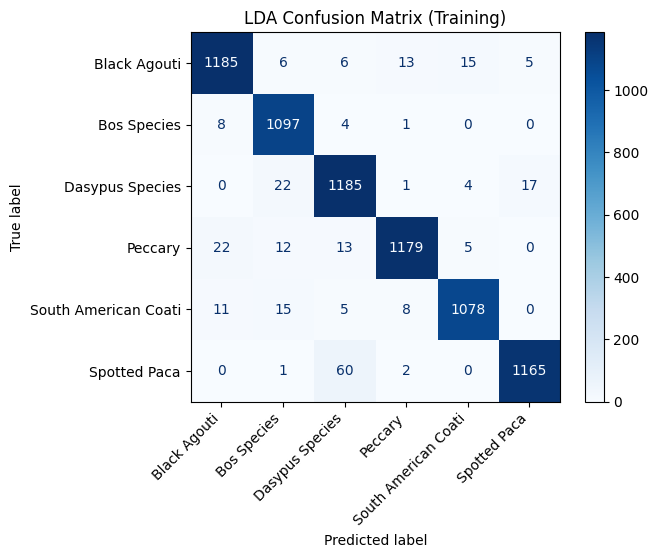

In [ ]:
# visualize confusion matrix
# Confusion matrix
print('Best-performing model: LDA Leaset Square with Shrinkage=0.4')
cm = confusion_matrix(y, y_pred)
label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Training)')
plt.show()

In [ ]:
# Check Species Labels
print(f'Peccary count = {22+1+11+1192+5+0 = }')
print(f'Black Agouti count = {1189+3+8+10+13+7 = }')
print(f'Dasypus Species count = {0+1+1193+1+1+33 = }')
print(f'Spotted Paca count = {0+0+67+2+0+1159 = }')
print(f'South American Coati count = {10+6+3+2+1096 = }')
print(f'Bos Species count = {2+1107+0+0+1+0 = }')

Peccary count = 22+1+11+1192+5+0 = 1231
Black Agouti count = 1189+3+8+10+13+7 = 1230
Dasypus Species count = 0+1+1193+1+1+33 = 1229
Spotted Paca count = 0+0+67+2+0+1159 = 1228
South American Coati count = 10+6+3+2+1096 = 1117
Bos Species count = 2+1107+0+0+1+0 = 1110


In [ ]:
y.value_counts()

,count
label,
Peccary,1231
Black Agouti,1230
Dasypus Species,1229
Spotted Paca,1228
South American Coati,1117
Bos Species,1110


<Figure size 1500x1500 with 0 Axes>

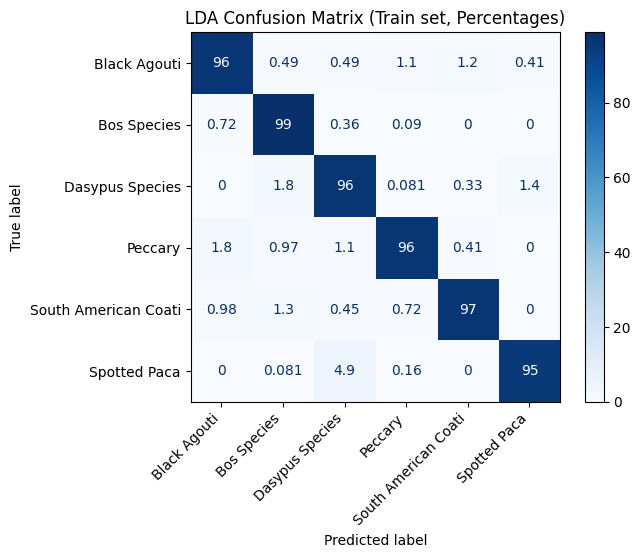

Best-performing model: Least Square LDA, with shrinkage = 0.4. Average values over K = 5 folds


In [ ]:
# Confusion Matrix (Percentage)

cm = confusion_matrix(y, y_pred)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100, decimals=4)

label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Train set, Percentages)')
plt.show()
print('Best-performing model: Least Square LDA, with shrinkage = 0.4. Average values over K = 5 folds')

## Confusion Matrix for Test Set

Best-performing model: LDA Leaset Square with Shrinkage=0.4


<Figure size 1500x1500 with 0 Axes>

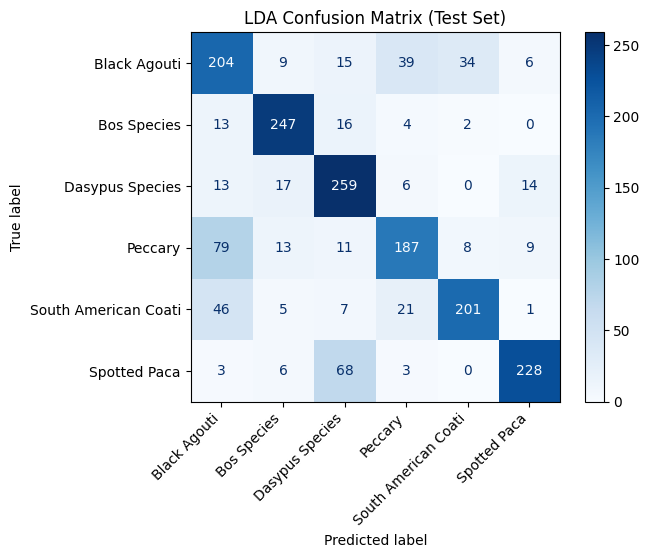

In [ ]:
# visualize confusion matrix
# Confusion matrix
print('Best-performing model: LDA Leaset Square with Shrinkage=0.4')
cm = confusion_matrix(y_test, y_pred_test)
label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Test Set)')
plt.show()

<Figure size 1500x1500 with 0 Axes>

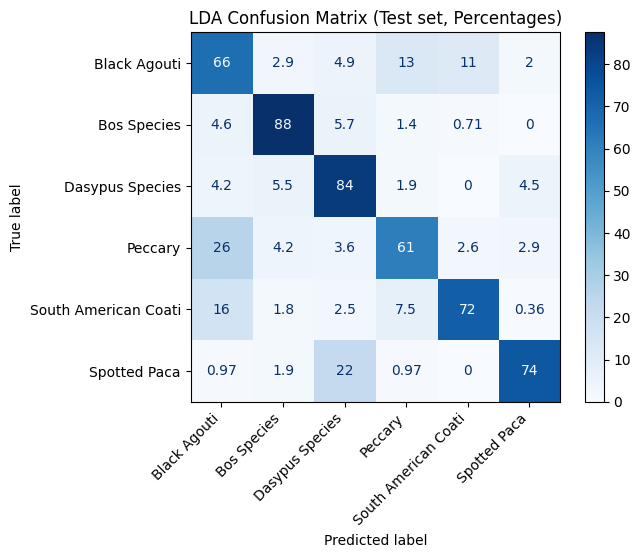

Best-performing model: Least Square LDA, with shrinkage = 0.4. Average values over K = 5 folds


In [ ]:
# Confusion Matrix (Percentage)

cm = confusion_matrix(y_test, y_pred_test)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100, decimals=3)

label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Test set, Percentages)')
plt.show()
print('Best-performing model: Least Square LDA, with shrinkage = 0.4. Average values over K = 5 folds')

## ROC Curve

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode Labels
# Creating labelEncoder
label_encoder = LabelEncoder()

# Assigning numerical values and storing in another column
label_encoder.fit_transform(y)


array([4, 5, 3, ..., 2, 2, 5])

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y)
y_onehot_train = label_binarizer.transform(y_test)
y_scores = best_model.fit(X, y).predict_proba(X_test)
y_onehot_train.shape


(1794, 6)

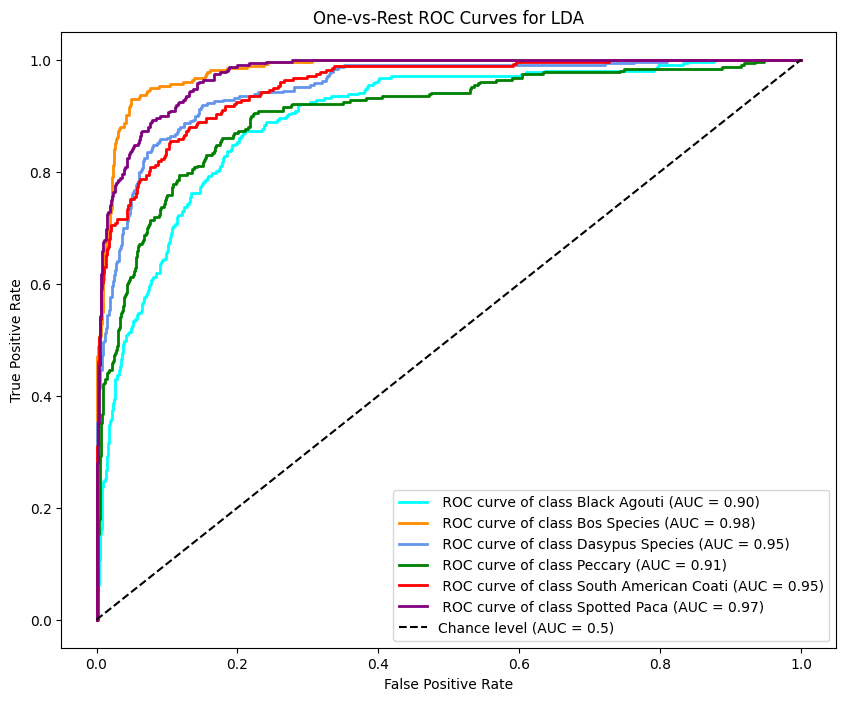

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, label in enumerate(best_model.classes_):
  class_of_interest = label
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  kwargs = {'lw':2}
  display = RocCurveDisplay.from_predictions(
      y_onehot_train[:, class_id],
      y_scores[:, class_id],
      name=f' ROC curve of class {class_of_interest}',
      ax=ax,
      color=colors[i],
      plot_chance_level=bool(i==5),
      **kwargs
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title="One-vs-Rest ROC Curves for LDA",
  )

# Gap Analysis

## Training

In [ ]:
# Wrongly Classified Images
